<a href="https://colab.research.google.com/github/alperkent/CIFAR10-CNN/blob/main/cmpe597_project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Next 4 cells are for installing a t-SNE package (tsne-cuda) that can utilize GPU to handle much faster calculations.

tsne-cuda: https://github.com/CannyLab/tsne-cuda

In [ ]:
!echo $PYTHONPATH
%env PYTHONPATH=

/env/python
env: PYTHONPATH=


In [ ]:
%%bash
MINICONDA_INSTALLER_SCRIPT=Miniconda3-4.5.4-Linux-x86_64.sh
MINICONDA_PREFIX=/usr/local
wget https://repo.continuum.io/miniconda/$MINICONDA_INSTALLER_SCRIPT
chmod +x $MINICONDA_INSTALLER_SCRIPT
./$MINICONDA_INSTALLER_SCRIPT -b -f -p $MINICONDA_PREFIX
conda install --channel defaults conda python=3.7 --yes
conda update --channel defaults --all --yes

PREFIX=/usr/local
installing: python-3.6.5-hc3d631a_2 ...
installing: ca-certificates-2018.03.07-0 ...
installing: conda-env-2.6.0-h36134e3_1 ...
installing: libgcc-ng-7.2.0-hdf63c60_3 ...
installing: libstdcxx-ng-7.2.0-hdf63c60_3 ...
installing: libffi-3.2.1-hd88cf55_4 ...
installing: ncurses-6.1-hf484d3e_0 ...
installing: openssl-1.0.2o-h20670df_0 ...
installing: tk-8.6.7-hc745277_3 ...
installing: xz-5.2.4-h14c3975_4 ...
installing: yaml-0.1.7-had09818_2 ...
installing: zlib-1.2.11-ha838bed_2 ...
installing: libedit-3.1.20170329-h6b74fdf_2 ...
installing: readline-7.0-ha6073c6_4 ...
installing: sqlite-3.23.1-he433501_0 ...
installing: asn1crypto-0.24.0-py36_0 ...
installing: certifi-2018.4.16-py36_0 ...
installing: chardet-3.0.4-py36h0f667ec_1 ...
installing: idna-2.6-py36h82fb2a8_1 ...
installing: pycosat-0.6.3-py36h0a5515d_0 ...
installing: pycparser-2.18-py36hf9f622e_1 ...
installing: pysocks-1.6.8-py36_0 ...
installing: ruamel_yaml-0.15.37-py36h14c3975_2 ...
installing: six-1.11

--2021-05-25 15:40:14--  https://repo.continuum.io/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.201.79, 104.18.200.79, 2606:4700::6812:c84f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.201.79|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://repo.anaconda.com/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh [following]
--2021-05-25 15:40:14--  https://repo.anaconda.com/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58468498 (56M) [application/x-sh]
Saving to: ‘Miniconda3-4.5.4-Linux-x86_64.sh’

     0K .......... .......... .......... .......... ..........  0% 19.2M 3s
    50K .......... .......... .......... .......... ..........  0%

In [ ]:
!yes Y | conda install faiss-gpu cudatoolkit=10.1 -c pytorch
!apt search openblas
!yes Y | apt install libopenblas-dev
!wget https://anaconda.org/CannyLab/tsnecuda/2.1.0/download/linux-64/tsnecuda-2.1.0-cuda101.tar.bz2
!tar xvjf tsnecuda-2.1.0-cuda101.tar.bz2 
!cp -r site-packages/* /usr/local/lib/python3.7/dist-packages/
!echo $LD_LIBRARY_PATH 
!ln -s /content/lib/libfaiss.so $LD_LIBRARY_PATH/libfaiss.so

Solving environment: / - \ | / - \ | / 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/linux-64::asn1crypto==0.24.0=py36_0
- \ | done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - cudatoolkit=10.1
    - faiss-gpu


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    asn1crypto-1.4.0           |             py_0          80 KB
    blas-1.0                   |              mkl           6 KB
    cudatoolkit-10.1.243       |       h6bb024c_0       347.4 MB
    faiss-gpu-1.6.3            |   py37h1a5d453_0        34.2 MB  pytorch
    intel-openmp-2021.2.0      |     h06a4308_610         1.3 MB
    mkl-2021.2.0               |     h06a4308_296       144.3 MB
    mkl-service-2.3.0          |   py37h27cfd23_1          55 KB
    mkl_fft-1.3.0

In [ ]:
# This does a t-SNE on 5000 points, so it should complete relatively quickly (1-2 seconds). If there are no error messages and it doesn't hang, you should be good to go.
import tsnecuda
tsnecuda.test()

-----------------------------
Actual code starts here:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tsnecuda import TSNE

In [ ]:
# unpickles CIFAR-10 data as instructed in README file
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [ ]:
# creates a dataset class suitable for loaders 
class Dataset(torch.utils.data.Dataset):
  def __init__(self, data, labels, transform):
        self.data = data
        self.labels = labels
        self.transform = transform

  def __len__(self):
        return len(self.data)

  def __getitem__(self, index):
        X = self.transform(self.data[index])
        y = self.labels[index] 
        return X, y

In [ ]:
# creates the model
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1, 1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.AvgPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, 1, 1)
        self.bn3 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128*4*4, 512)
        self.bn4 = nn.BatchNorm1d(512)
        self.dropout = nn.Dropout(0.1)
        self.fc2 = nn.Linear(512, 128)
        self.bn5 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # (N, 3, 32, 32)  -> (N, 32, 16, 16)
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # (N, 32, 16, 16) -> (N, 64, 8, 8)
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # (N, 64, 8, 8)   -> (N, 128, 4, 4)
        x = torch.flatten(x, 1)                         # (N, 128, 4, 4)  -> (N, 2048)
        x = self.dropout(x)
        x = F.relu(self.bn4(self.fc1(x)))  # (N, 2048) -> (N, 512)
        x = self.dropout(x)
        x = F.relu(self.bn5(self.fc2(x)))  # (N, 512)  -> (N, 128)
        x = self.fc3(x)                    # (N, 128)  -> (N, 10)
        return x

    def features(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # (N, 3, 32, 32)  -> (N, 32, 16, 16)
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # (N, 32, 16, 16) -> (N, 64, 8, 8)
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # (N, 64, 8, 8)   -> (N, 128, 4, 4)
        x = torch.flatten(x, 1)                         # (N, 128, 4, 4)  -> (N, 2048)
        return x

In [ ]:
# creates a TSNE model and plots it
def plot_TSNE(network, loader, epoch):
    data = []
    targets = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            outputs = network.features(inputs).cpu().numpy()
            data.append(outputs)
            targets.append(labels.cpu().numpy())
    data = np.array(data).reshape((-1, 2048))
    targets = np.array(targets).reshape((-1))
    tsne_data = TSNE(perplexity=50, n_iter=1000).fit_transform(data)
    for i in range(len(classes)):
      plt.scatter(tsne_data[np.where(targets[:] == i), 0], tsne_data[np.where(targets[:] == i), 1], s=0.5, label=classes[i])
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('Latent space at epoch %d' % (epoch+1))
    plt.show()

In [ ]:
# uses GPU to train the model determinisitically for reproducibility
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.benchmark = False
torch.manual_seed(421)
np.random.seed(421)
torch.use_deterministic_algorithms(True)

In [ ]:
# loads training data 
train1 = unpickle('drive/MyDrive/CogSci/Spring 21/CMPE597/Project 2/cifar10_data/cifar10_data/data_batch_1')
train2 = unpickle('drive/MyDrive/CogSci/Spring 21/CMPE597/Project 2/cifar10_data/cifar10_data/data_batch_2')
train3 = unpickle('drive/MyDrive/CogSci/Spring 21/CMPE597/Project 2/cifar10_data/cifar10_data/data_batch_3')
train4 = unpickle('drive/MyDrive/CogSci/Spring 21/CMPE597/Project 2/cifar10_data/cifar10_data/data_batch_4')
trainset = np.concatenate((train1[b'data'], train2[b'data'], train3[b'data'], train4[b'data'])).reshape((-1, 3, 32, 32)).transpose((0, 2, 3, 1))
trainlabels = torch.tensor(np.concatenate((train1[b'labels'], train2[b'labels'], train3[b'labels'], train4[b'labels'])), dtype=torch.long, device=device)
del train1, train2, train3, train4

# loads validation data
train5 = unpickle('drive/MyDrive/CogSci/Spring 21/CMPE597/Project 2/cifar10_data/cifar10_data/data_batch_5')
valset = train5[b'data'].reshape((-1, 3, 32, 32)).transpose((0, 2, 3, 1))
vallabels = torch.tensor(train5[b'labels'], dtype=torch.long, device=device)
del train5

# loads test data
test = unpickle('drive/MyDrive/CogSci/Spring 21/CMPE597/Project 2/cifar10_data/cifar10_data/test_batch')
testset = test[b'data'].reshape((-1, 3, 32, 32)).transpose((0, 2, 3, 1))
testlabels = torch.tensor(test[b'labels'], dtype=torch.long, device=device)
del test

# loads class labels
label_info = unpickle('drive/MyDrive/CogSci/Spring 21/CMPE597/Project 2/cifar10_data/cifar10_data/batches.meta')
classes = [x.decode('utf-8') for x in label_info[b'label_names']] 
del label_info

In [ ]:
# hyperparameters
batch_size = 64
max_epochs = 100
learning_rate = 0.001

In [ ]:
# transformations
means = [trainset[:, :, :, 0].mean()/255, 
         trainset[:, :, :, 1].mean()/255, 
         trainset[:, :, :, 2].mean()/255]
stds = [trainset[:, :, :, 0].std()/255, 
        trainset[:, :, :, 1].std()/255, 
        trainset[:, :, :, 2].std()/255]
transform_train = transforms.Compose([
    transforms.ToPILImage(),                                  
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(means, stds)])
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(means, stds)])

In [ ]:
# loaders
training_set = Dataset(trainset, trainlabels, transform_train)
trainloader = torch.utils.data.DataLoader(training_set, batch_size=batch_size, shuffle=True)

validation_set = Dataset(valset, vallabels, transform)
valloader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size)

test_set = Dataset(testset, testlabels, transform)
testloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


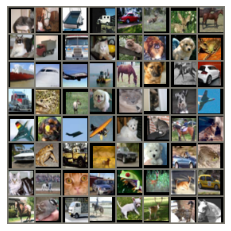

cat horse truck truck automobile deer deer horse cat truck truck cat cat dog dog frog ship airplane airplane ship horse dog horse automobile truck frog deer dog cat cat dog airplane airplane dog airplane airplane dog cat horse cat automobile frog truck deer automobile dog automobile frog cat horse cat automobile frog deer deer automobile horse bird truck horse dog deer cat horse


In [ ]:
# functions to show an image
def imshow(img):
    npimg = np.transpose(img.numpy(), (1, 2, 0))
    npimg = npimg * stds + means
    plt.imshow(npimg)
    plt.axis('off')
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%s' % classes[labels[j]] for j in range(batch_size)))

In [ ]:
# initializes the network, loss function and optimizer
network = CNN()
network.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(network.parameters(), lr=learning_rate)
# optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=0.9)
# optimizer = optim.Adagrad(network.parameters(), lr=learning_rate)
# optimizer = optim.RMSprop(network.parameters(), lr=learning_rate)

In [ ]:
# initializes early stopping parameters
stop = {'patience': 5, 'wait': 0, 'best_error': 1, 'best_epoch': 0}

# path to file for saving model parameters
PATH = 'drive/MyDrive/CogSci/Spring 21/CMPE597/Project 2/model.py'

Loss at epoch                  1: 0.022364
Training accuracy at epoch     1: 48.1625 %
Validation accuracy at epoch   1: 60.0200 %
-------------------------------------------


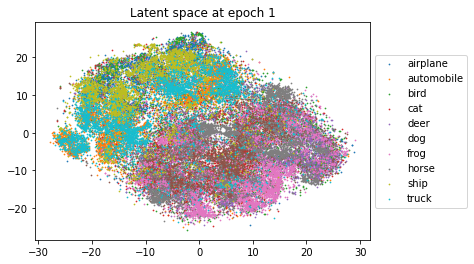

-------------------------------------------
Loss at epoch                  2: 0.016724
Training accuracy at epoch     2: 61.9475 %
Validation accuracy at epoch   2: 66.3900 %
-------------------------------------------
Loss at epoch                  3: 0.014550
Training accuracy at epoch     3: 66.7200 %
Validation accuracy at epoch   3: 71.0700 %
-------------------------------------------
Loss at epoch                  4: 0.013096
Training accuracy at epoch     4: 70.3950 %
Validation accuracy at epoch   4: 72.5500 %
-------------------------------------------
Loss at epoch                  5: 0.012168
Training accuracy at epoch     5: 72.4950 %
Validation accuracy at epoch   5: 73.3000 %
-------------------------------------------
Loss at epoch                  6: 0.011411
Training accuracy at epoch     6: 74.1375 %
Validation accuracy at epoch   6: 75.7600 %
-------------------------------------------
Loss at epoch                  7: 0.010782
Training accuracy at epoch     7: 75.4

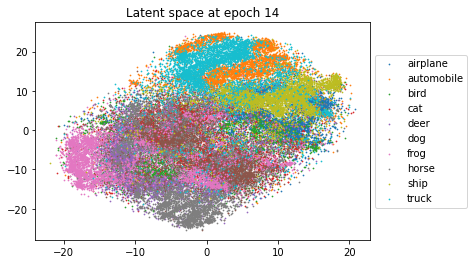

-------------------------------------------
Loss at epoch                 15: 0.007799
Training accuracy at epoch    15: 82.2750 %
Validation accuracy at epoch  15: 80.5200 %
-------------------------------------------
Loss at epoch                 16: 0.007539
Training accuracy at epoch    16: 83.0175 %
Validation accuracy at epoch  16: 79.1400 %
-------------------------------------------
Loss at epoch                 17: 0.007278
Training accuracy at epoch    17: 83.5725 %
Validation accuracy at epoch  17: 80.4900 %
-------------------------------------------
Loss at epoch                 18: 0.007073
Training accuracy at epoch    18: 83.9550 %
Validation accuracy at epoch  18: 80.3300 %
-------------------------------------------
Loss at epoch                 19: 0.006826
Training accuracy at epoch    19: 84.6475 %
Validation accuracy at epoch  19: 79.9500 %
-------------------------------------------
Loss at epoch                 20: 0.006752
Training accuracy at epoch    20: 84.7

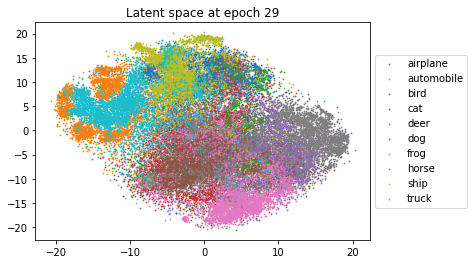

-------------------------------------------
Loss at epoch                 30: 0.005216
Training accuracy at epoch    30: 88.1100 %
Validation accuracy at epoch  30: 81.6000 %
-------------------------------------------
Loss at epoch                 31: 0.005150
Training accuracy at epoch    31: 88.2325 %
Validation accuracy at epoch  31: 82.1400 %
-------------------------------------------
Terminated training for early stopping at epoch 31
Final epoch for best model: 26
Final training accuracy: 87.2100 %
Final validation accuracy: 82.1400 %


In [ ]:
# loops over epochs
losses = []
train_acc = []
val_acc = []
for epoch in range(max_epochs):
    # training
    running_loss = 0.0
    train_correct = 0
    train_total = 0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = network(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        running_loss += loss.item()
    train_acc.append(100*train_correct/train_total)
    losses.append(running_loss/train_total)
        
    # validation
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in valloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = network(inputs)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    val_acc.append(100*val_correct/val_total)

    print('Loss at epoch %18d: %f' % (epoch+1, losses[-1]))
    print('Training accuracy at epoch %5d: %.4f %%' % (epoch+1, train_acc[-1]))
    print('Validation accuracy at epoch %3d: %.4f %%' % (epoch+1, val_acc[-1]))
    print('-------------------------------------------')

    # plots t-SNE at the beginning, middle, and end of training
    if epoch == 0 or epoch == 13 or epoch == 28:
        plot_TSNE(network, trainloader, epoch)
        print('-------------------------------------------')

    # evaluates early stopping and saves the model parameters accordingly
    stop['current_error'] = 1 - val_acc[-1] / 100
    if stop['current_error'] < stop['best_error']:
        stop['best_error'] = stop['current_error']
        stop['best_epoch'] = epoch
        torch.save(network.state_dict(), PATH)
        stop['wait'] = 1
    else:
        if stop['wait'] >= stop['patience']:
            print('Terminated training for early stopping at epoch %d' % (epoch+1))
            break
        stop['wait'] += 1

print('Final epoch for best model: %d' % (stop['best_epoch']+1))
print('Final training accuracy: %.4f %%' % train_acc[stop['best_epoch']])
print('Final validation accuracy: %.4f %%' % val_acc[stop['best_epoch']])

In [ ]:
# reloads best model
network = CNN()
network.to(device)
network.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = network(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Test accuracy: %.4f %%' % (100*correct/total))

Test accuracy: 81.5600 %


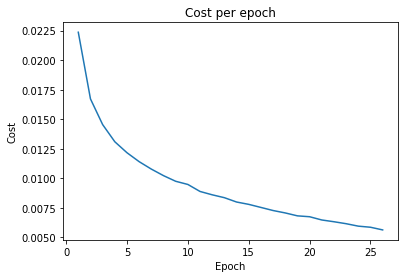

In [ ]:
# plots costs over epochs
plt.plot(range(1, stop['best_epoch']+2), losses[:stop['best_epoch']+1])
plt.title('Cost per epoch')
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.show()

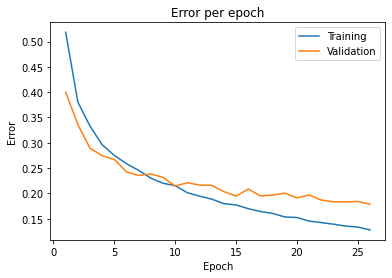

In [ ]:
# plots training and validation errors over epochs
plt.plot(range(1, stop['best_epoch']+2), [1-x/100 for x in train_acc[:stop['best_epoch']+1]], label='Training')
plt.plot(range(1, stop['best_epoch']+2), [1-x/100 for x in val_acc[:stop['best_epoch']+1]], label='Validation')
plt.title('Error per epoch')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.show()